<a href="https://colab.research.google.com/github/hiro201025/othello_AI/blob/main/RLpn_DQN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat
#import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
CUR_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
if CUR_PATH not in sys.path:
  sys.path.append(CUR_PATH)

#for load params of trained model
SL_MODEL_NAME = "conv4_bn_mini"
SL_No = 30
SL_PARAM_NAME = f"SLpn_{SL_MODEL_NAME}_{SL_No}"
SL_PARAM_PATH = os.path.join(CUR_PATH, "SLpn_params", f"{SL_PARAM_NAME}.pth")

#for save params of policy model
MODEL_NAME = "dqn_conv4"
No = 22 #01: determinism select_action lr 2e-5 2: probability theory one lr->1e-6? 21:vs random determine 22: prob
PARAM_NAME = f"RLpn_{MODEL_NAME}_{No}"
PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{PARAM_NAME}.pth")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
import gym
import tools
env = gym.make("othello-v0")

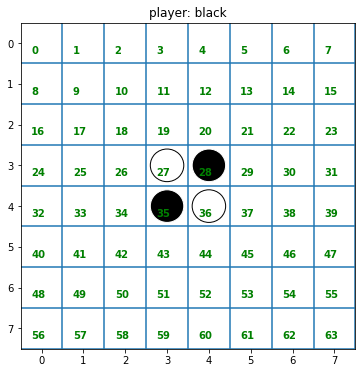

[19, 26, 37, 44]
placed: 44
positions: [29, 43, 45]
placed: 43
positions: [9, 10, 20, 21, 26, 34, 38, 47, 50, 51, 53, 54, 55]
placed: 31
positions: [34, 40, 51, 53, 54, 55]
placed: 58
positions: [6, 14, 22, 24, 25, 33, 34, 39, 40, 49, 53, 59, 61, 63]
placed: 25
positions: [3, 4, 5, 6, 14, 21, 22, 23, 24, 32, 39, 49, 57, 59]
placed: 63
positions: [4, 5, 7, 15, 22, 23, 39, 59]


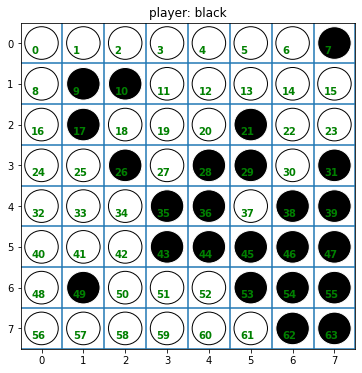

-1.0 2


In [ ]:
env.reset()
env.render()
posts, _, _ = env.next_place
print(posts)
done = False
ct = 0
while not done:
  board, action, next, reward, done, player = env.step()
  if ct%10 == 0:
    #env.render()
    posts, _, _ = env.next_place
    print("placed:", action)
    print("positions:", posts)
  ct += 1
env.render()
print(reward, player)
#white, black = 1, 2

#Hyper Parameters

In [ ]:
LR = 0.000001
GAMMA = 0.999
buffer_limit = 5000
BATCH_SIZE = 64

#Replay memory

In [ ]:
#transition = (board, player, reward)

class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.reset()


  def reset(self):
    self.idx = 0
    self.states = []
    self.actions = []
    self.nexts = []
    self.players = []
  

  def push(self, state, action, next_state, player):
    if self.idx < self.capacity:
      self.states.append([None])
      self.actions.append(None)
      self.nexts.append([None])
      self.players.append(None)
    self.states[self.idx] = state
    self.actions[self.idx] = action
    self.nexts[self.idx] = next_state
    self.players[self.idx] = player
    self.idx = (self.idx + 1) % self.capacity


  def __getitem__(self, idx):
    return self.states[idx], self.actions[idx], self.nexts[idx], self.players[idx]


  def sample(self, batch_size):
    idxs = [i for i in range(self.idx)]

    if batch_size >= self.idx:
      return idxs, (self.states, self.actions, self.nexts, self.players)

    else:
      idxs = random.sample(idxs, batch_size)
      return idxs, ([self.states[idx] for idx in idxs], [self.actions[idx] for idx in idxs],
                    [self.nexts[idx] for idx in idxs], [self.players[idx] for idx in idxs])
  

  def __len__(self):
    return self.idx


  def __call__(self, mode = "all"):
    if mode == "all":
      return (self.states, self.actions, self.nexts, self.players)
    elif mode == "reward":
      return self.players
    else:
      return 0

In [ ]:
player_name = ("white", "black")
test_memory = ReplayMemory(70*3)
reward_list = []
for _ in range(3):
  env.reset()
  start = len(test_memory)
  while not env.done:
    board, action, next, reward, done, player = env.step() #more info: skip or not
    posts, _, _ = env.next_place
    test_memory.push(board.copy(), [action], next.copy(), player)
    if len(posts) == 0:
      print(board)
      print(next)
      print("action:", action)
      print(f"player: {player} reward: {reward} done: {done}")
  last = len(test_memory)
  print(f"start: {start} last: {last-1}")
  color = (int(player + (reward+1)//2)) % 2
  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  print(f"win: {player_name[color]} {winner}")
  player_list = test_memory("reward")
  reward_list[len(reward_list):] = [0.0 if winner == 0 else 1.0 if x == winner else -1.0 for x in player_list[start:last]]
print(len(test_memory))
print(test_memory[20])
print(test_memory.sample(1))
#print(reward_list[start:last])
#print(test_memory.sample(10))
#env.render()

[[2 2 2 2 2 2 2 2]
 [2 1 1 1 1 2 2 2]
 [2 1 1 2 2 1 1 2]
 [2 1 1 2 2 1 1 2]
 [2 1 2 1 1 2 2 2]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 0 2 2]]
[[2 2 2 2 2 2 2 2]
 [2 1 1 1 1 2 2 2]
 [2 1 1 2 2 1 1 2]
 [2 1 1 2 2 1 1 2]
 [2 1 1 1 1 1 2 2]
 [2 2 2 1 2 1 2 2]
 [2 2 2 2 1 1 2 2]
 [2 2 2 2 2 1 2 2]]
action: 61
player: 2 reward: 1.0 done: True
start: 0 last: 59
win: black 2
[[2 1 1 1 1 1 2 0]
 [2 2 1 1 1 1 2 2]
 [2 2 1 1 1 1 2 2]
 [1 1 1 2 2 1 2 2]
 [1 1 2 2 2 2 2 2]
 [1 1 2 1 2 1 2 1]
 [2 2 2 1 1 2 2 1]
 [2 2 2 2 2 2 2 1]]
[[2 1 1 1 1 1 1 1]
 [2 2 1 1 1 1 1 1]
 [2 2 1 1 1 1 2 1]
 [1 1 1 2 2 1 2 1]
 [1 1 2 2 2 2 2 1]
 [1 1 2 1 2 1 2 1]
 [2 2 2 1 1 2 2 1]
 [2 2 2 2 2 2 2 1]]
action: 7
player: 2 reward: -1.0 done: True
start: 60 last: 119
win: white 1
[[2 2 2 2 2 2 2 2]
 [1 2 2 1 2 2 1 1]
 [1 2 2 2 1 2 1 1]
 [1 2 2 2 1 2 2 1]
 [1 2 2 1 2 2 1 1]
 [1 2 2 2 2 2 1 2]
 [1 2 2 2 2 2 2 2]
 [1 0 2 2 2 2 2 2]]
[[2 2 2 2 2 2 2 2]
 [1 2 2 1 2 2 1 1]
 [1 2 2 2 1 2 1 1]
 [1 2 2 2 1 1 2 1]
 [1 2 2

#making model

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making Datasets

In [ ]:
#board => 3 dim state
#player = 1: white, 2: black
class DQNDatasets(Dataset):
  def __init__(self, state, action, next_state, player, reward):
    self.state = state
    self.action = action
    self.next_state = next_state
    self.player = player #player = next_player
    self.reward = reward

  def __len__(self):
    return len(self.player)
  
  def __getitem__(self, idx):
    state = self.state[idx].reshape((-1, 8, 8)).astype("float32")
    white_st = np.where(state == 3 - self.player[idx], 1, 0)
    black_st = np.where(state == self.player[idx], 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 1).reshape(3, 8, 8) #axis check

    action = self.action[idx]

    next_state = self.next_state[idx].reshape((-1, 8, 8)).astype("float32")
    white_nst = np.where(next_state == self.player[idx], 1, 0)
    black_nst = np.where(next_state == 3 - self.player[idx], 1, 0)
    bw_nst = np.where(next_state > 0, 1, 0)
    next_state = np.stack([bw_nst, white_nst, black_nst], axis = 1).reshape(3, 8, 8)

    reward = self.reward[idx]

    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    next_state = torch.tensor(next_state).float()
    reward = torch.tensor(reward).float()
    return state, action, next_state, reward

#making select action leading e-greedy rule

In [ ]:
EPS_START = 0.9 #max
EPS_END = 0.05 #min
EPS_DECAY = 1000 #decay to decrease

def select_action(epoch, state, player, policy_model):
  p = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * epoch / EPS_DECAY)
  if p > eps_threshold:

    state = state.astype("float32")
    white_st = np.where(state == 3 - player, 1, 0)
    black_st = np.where(state == player, 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8) #axis check
    state = torch.tensor(state).float()
    state = state.to(device)

    #state, _, _, _ = DQNDatasets(state, 0, state, player, 0)[0]
    policy_model.eval()
    with torch.no_grad():
      pred = policy_model(state)
      #return pred.max(1)[1].reshape(-1, 1) #determinism
      pred = nn.Softmax(dim=0)(pred)
      return torch.multinomial(pred, 1) #probability theory
  else:
    return torch.tensor([-1], device = device, dtype = torch.long)

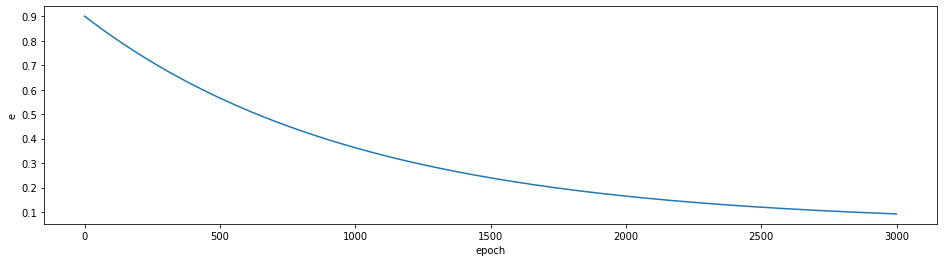

In [ ]:
e = []
for i in range(3000):
  eg = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i / EPS_DECAY)
  e.append(eg)
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_xlabel("epoch")
ax.set_ylabel("e")
ax.plot(e)
plt.show()

#making optimizer

In [ ]:
def optimize_model(policy_model, target_model, memory, reward, wrong=0):
  tdloss = 0
  
  state, action, next_state, player = memory
  dqn_dataset = DQNDatasets(state, action, next_state, player, reward)
  dqn_loader = DataLoader(dqn_dataset, batch_size = BATCH_SIZE, shuffle = True)

  for state, action, next_state, reward in dqn_loader:
    state = state.to(device)
    action = action.to(device)
    next_state = next_state.to(device)
    reward = reward.to(device)
    #Q(s_t, a)
    #calculate Q(s_t) get a = actions
    #all actions lead policy_net
    policy_model.train()
    pred =  policy_model(state)
    state_action_values = pred.gather(1, action)
    
    #calcurate V(s_{t+1}) about all next states.
    #Expected value at next state on non_final_next_ by target net before update.
    #this values are 0 at final and expected values on next at others.
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    next_state_values = target_model(next_state).max(1)[0].detach()
    #calculate expected Q value
    #more expected_sa_value, less next_state_value -> -1*
    expected_state_action_values = (-1 * next_state_values * GAMMA) + reward
    if wrong:
      expected_state_action_values = reward

    #calculate Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    #update model param
    optimizer.zero_grad()
    loss.backward()
    for param in policy_model.parameters():
      param.grad.data.clamp_(-1, 1)
    optimizer.step()
    tdloss += loss.item() / len(dqn_loader)
  return tdloss

#making model

In [ ]:
policy_model = Conv4_bn_mini().to(device)
policy_model.load_state_dict(torch.load(SL_PARAM_PATH, map_location = device))
target_model = Conv4_bn_mini().to(device)
target_model.load_state_dict(policy_model.state_dict())
target_model.eval()
#torch.save(model.state_dict(), PARAM_PATH)

Conv4_bn_mini(
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
)

In [ ]:
if False:
  state, action, next_state, player = test_memory()
  dqn_dataset = DQNDatasets(state, action, next_state, player, reward_list)
  dqn_loader = DataLoader(dqn_dataset, batch_size = 2, shuffle = True)
  i = 0
  for state, action, next_state, reward in dqn_loader:
    if i == 0:
      i += 1
      state = state.to(device)
      action = action.to(device)
      state_action = policy_model(state)#.gather(1, action)
      print(state)
      print(state.shape)
      print(state_action.shape)
      print(action.shape)
      print(state_action)
      print(action)
      state_action_values = policy_model(state).gather(1, action)
      print(state_action_values)

#vs random or model

In [ ]:
W, B = 1, 2
color = ("white", "black")
num_battle = 100
op_model = Conv4_bn_mini().to(device)
op_model.load_state_dict(torch.load(SL_PARAM_PATH, map_location = device))
op_model.eval()


def np_to_feature(state, player):
  state = state.astype("float32")
  white_st = np.where(state == 3 - player, 1, 0)
  black_st = np.where(state == player, 1, 0)
  bw_st = np.where(state > 0, 1, 0)
  state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
  state = torch.tensor(state).float()
  state = state.to(device)
  return state


def op_select_action(state, player, mode="SLpn"):
  state = np_to_feature(state, player)
  if mode == "SLpn":
     with torch.no_grad():
      action = op_model(state).max(1)[1]
  else: #random
    action = torch.tensor(-1, device = device, dtype = torch.long)
  return action
  

def vs_play(model, mode="random", battles=num_battle):
  model.eval()
  for play in (W, B):
    wincnt = [0, 0] #white, black
    accuracy = [0, 0] #Right Wrong
    for _ in range(battles):
      env.reset()
      while not env.done:
        player = env.player
        state = env.render("rgb_array")
        if player == play:#play : policy model
          state = np_to_feature(state, player)
          with torch.no_grad():
            action = model(state).max(1)[1]
        else: #play : opposite
          if mode == "random": #random
            action = torch.tensor(-1, device = device, dtype = torch.long)

          elif mode == "SLpn": #SL trained model
            action = op_select_action(state, player, mode="SLpn")

          else:
            action = torch.tensor(-1, device = device, dtype = torch.long)


        _, actual_action, _, reward, _, player = env.step(action.item())
        if player != play:
          #print(action.item(), actual_action)
          if actual_action < 0:
            pass
          elif action.item() == actual_action:
            accuracy[0] += 1
          else:
            accuracy[1] += 1

      winner = (player + (int(reward)+1)//2 )%2 + 1
      winner *= int(reward**2)
      wincnt[winner - 1] += 1
    print(f"test: {color[play-1]}: vs {mode}: win rate: {wincnt[play-1]/sum(wincnt):.2f} placed accuracy: {accuracy[0]/sum(accuracy):.4f}")

#training loop

In [ ]:
EPOCH = 3000 #100 takes 25 minites
num_episodes = 2
CAPA = num_episodes * 70
memory_batch_size = BATCH_SIZE//2
TEST_FREC = 10
TARGET_UPDATE = 2
LR = 0.00002
optimizer = optim.RMSprop(policy_model.parameters(), lr = LR)
episode_durations = []
loss_data = []
print(f"train model: {MODEL_NAME}_{No} Epoch: {EPOCH} episode: 2*{num_episodes} target update: {TARGET_UPDATE} learning rate: {LR}")

memory = [ReplayMemory(CAPA), ReplayMemory(CAPA)] #white, black
wrong_memory = ReplayMemory(CAPA)

for epoch in range(EPOCH):
  rewards = [[], []] #white, black
  player = 2 #black
  cnt = 0
  memory[W-1].reset()
  memory[B-1].reset()
  wrong_memory.reset()
  for i_episode in range(num_episodes):
    for play in (W, B):
      env.reset()
      stone_rate = [] # sum(stones)/64
      start = len(memory[play-1])

      while not env.done:
        cnt += 1
        state = env.render("rgb_array")
        if player == play: #play: training model
          #do in actions
          pred_action = select_action(epoch, state.copy(), player, policy_model)
          state, action, next_state, reward, done, player = env.step(pred_action.item())
          stone_rate.append(np.count_nonzero(state > 0) / 64)

          #save state in memory
          if action >= 0:
            memory[play-1].push(state.copy(), [action], next_state.copy(), 3-player)

            if pred_action.item() != action and pred_action.item() >= 0:
              wrong_memory.push(state.copy(), [pred_action.item()], next_state.copy(), 3-player)
        
        else: #play: trained model
          #pred_action = op_select_action(state, player, mode="SLpn")
          pred_action = torch.tensor(-1, device = device, dtype = torch.long)
          state, action, next_state, reward, done, player = env.step(pred_action.item())

        #step next state
        state = next_state.copy()

      last = len(memory[play-1])
      #making reward list
      winner = (player + (int(reward)+1)//2 )%2 + 1
      winner *= int(reward**2) #winner = {drow: 0, white: 1, black: 2}
      #last_reward = {lose: -1.0, drow: 0.3, win:1.0}
      #timed_reward = last_reward * sum(stones)/64
      players = memory[play-1]("reward")
      complex_reward = []
      for i in range(start, last):
        if winner == 0:
          last_reward = 0.3
        elif winner == players[i]:
          last_reward = 1.0
        else:
          last_reward = -1.0
        #timed_reward = stone_rate[i-start] * last_reward
        timed_reward = last_reward
        complex_reward.append(timed_reward)
      rewards[play-1][len(rewards[play-1]):] = complex_reward

  #do optimized step on target net
  states_bt, nexts_bt, actions_bt, players_bt, rewards_bt = [], [], [], [], []
  for play in (W, B):
    idxs, (states, nexts, actions, players) = memory[play-1].sample(memory_batch_size)
    for smp, bt in zip((states, nexts, actions, players), (states_bt, nexts_bt, actions_bt, players_bt)):
      bt[len(bt):] = smp
    rewards_bt[len(rewards_bt):] = [rewards[play-1][i] for i in idxs]
  tdloss = optimize_model(policy_model, target_model, 
                          (states_bt, nexts_bt, actions_bt, players_bt), rewards_bt)
  loss_data.append(tdloss)
  #reward of wrong placed action is -1.0
  wrong_cnt = len(wrong_memory)
  if wrong_cnt > 0:
    wrong_rewards = [-20.0] * wrong_cnt
    _ = optimize_model(policy_model, target_model, wrong_memory("all"), wrong_rewards, wrong=1)
  #print data
  episode_durations.append(cnt)
  print(f"Epoch: {epoch} Train: {memory_batch_size*2} / Episodes: {cnt} TDLoss: {tdloss:.4f} Wrong action: {wrong_cnt}/{cnt}")
  torch.save(policy_model.state_dict(), PARAM_PATH)

  if epoch % TEST_FREC == 0:
    vs_play(policy_model, mode="SLpn", battles=10)
  #update target net by policy_net params
  if epoch % TARGET_UPDATE == 0:
    target_model.load_state_dict(policy_model.state_dict())

vs_play(policy_model, mode="SLpn", battles=10)
print("Completed Training!")

train model: dqn_conv4_22 Epoch: 3000 episode: 2*2 target update: 2 learning rate: 2e-05
Epoch: 0 Train: 64 / Episodes: 242 TDLoss: 17.9115 Wrong action: 10/242
test: white: vs SLpn: win rate: 0.00 placed accuracy: 1.0000
test: black: vs SLpn: win rate: 1.00 placed accuracy: 1.0000
Epoch: 1 Train: 64 / Episodes: 242 TDLoss: 18.1307 Wrong action: 10/242
Epoch: 2 Train: 64 / Episodes: 242 TDLoss: 15.9877 Wrong action: 11/242
Epoch: 3 Train: 64 / Episodes: 240 TDLoss: 15.2372 Wrong action: 12/240
Epoch: 4 Train: 64 / Episodes: 241 TDLoss: 16.6594 Wrong action: 12/241
Epoch: 5 Train: 64 / Episodes: 243 TDLoss: 15.8917 Wrong action: 7/243
Epoch: 6 Train: 64 / Episodes: 240 TDLoss: 15.2896 Wrong action: 10/240
Epoch: 7 Train: 64 / Episodes: 241 TDLoss: 14.9827 Wrong action: 10/241
Epoch: 8 Train: 64 / Episodes: 241 TDLoss: 15.3930 Wrong action: 9/241
Epoch: 9 Train: 64 / Episodes: 242 TDLoss: 15.2001 Wrong action: 12/242
Epoch: 10 Train: 64 / Episodes: 240 TDLoss: 16.0403 Wrong action: 7/240

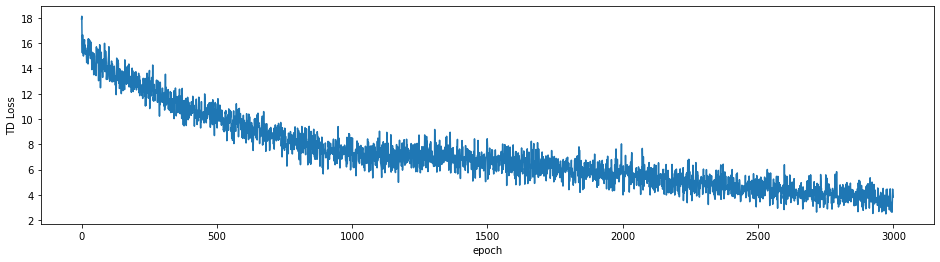

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_xlabel("epoch")
ax.set_ylabel("TD Loss")
ax.plot(loss_data)
plt.show()

#vs. random

In [ ]:
W, B = 1, 2
policy_model.eval()
policy_play = B
wincnt = [0, 0] #white, black
accuracy = [0, 0] #Right Wrong
for _ in range(100): #1000 loops takes 70 seconds
  env.reset()
  while not env.done:
    player = env.player
    if player == policy_play:#black = policy model
      state = env.render("rgb_array")
      state = state.astype("float32")
      white_st = np.where(state == 3 - player, 1, 0)
      black_st = np.where(state == player, 1, 0)
      bw_st = np.where(state > 0, 1, 0)
      state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
      state = torch.tensor(state).float()
      state = state.to(device)
      with torch.no_grad():
        action = policy_model(state).max(1)[1]
    else: #white = random
      action = torch.tensor(-1, device = device, dtype = torch.long)

    _, actual_action, _, reward, _, player = env.step(action.item())
    if player != policy_play:
      #print(action.item(), actual_action)
      if actual_action < 0:
        pass
      elif action.item() == actual_action:
        accuracy[0] += 1
      else:
        accuracy[1] += 1

  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  wincnt[winner - 1] += 1
print(wincnt)
print(f"policy model won {wincnt[1]} times in {sum(wincnt)} battle")
print(f"win rate: {wincnt[1]/sum(wincnt):.4f}")
print(f"placed accuracy: {accuracy[0]/sum(accuracy):.4f} Right, Wrong: {accuracy}")

[18, 82]
policy model won 82 times in 100 battle
win rate: 0.8200
placed accuracy: 0.9833 Right, Wrong: [2998, 51]


#view heatmap

In [ ]:
white, black = 1, 2
color = ("white", "black")
def policy_heatmap(state, pred, posts, player): 
  fig, ax= plt.subplots(1, 1, figsize=(6, 6))
  pred = pred.reshape(8, 8)
  #sns.heatmap(pred, square = True, ax = ax)
  plt.imshow(pred, interpolation='nearest', cmap='magma')
  plt.colorbar()

  for y in range(8):
    for x in range(8):
      st = state[y][x]

      if x + 8*y in posts:
          r = pat.Rectangle(xy=(x-0.38, y-0.38), width=0.8, height=0.8, linewidth=2, ec='g', fill=False)
          ax.add_artist(r)

      if st > 0:
        if st == 1:
          fc, ec = 'w', 'k' #face=white, edge=black
        elif st == 2:
          fc, ec = 'k', 'w'
        c = pat.Circle(xy=(x, y), radius=0.4, fc=fc, ec=ec, fill = True)
        ax.add_artist(c)

  pred_num = np.argsort(-pred.reshape(64))
  for y in range(8):
    for x in range(8):
      px = pred_num[x + y*8] % 8
      py = pred_num[x + y*8] // 8
      ax.text(px-0.25, py+0.25, f"{x + y*8 + 1}", size=10, color='green', fontweight='bold')
  if player == white:
    title = "player: white"
  else:
    title = "player: black"
  ax.set_title(title)
  plt.show()

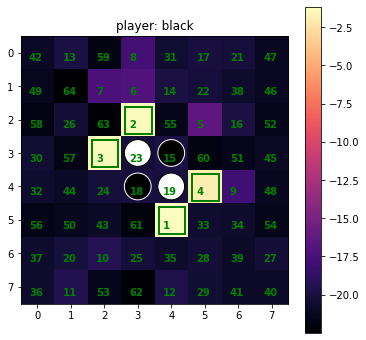

44 44
[29, 43, 45]


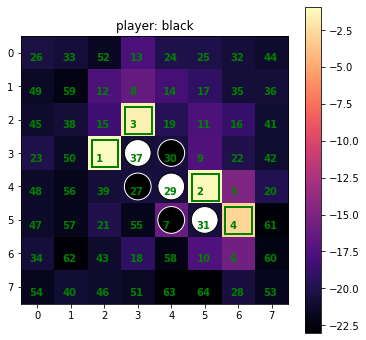

26 26
[18, 20, 34, 43, 52]


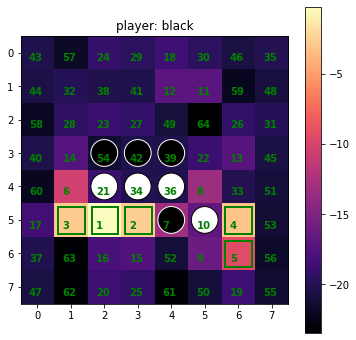

42 42
[18, 20, 33, 43, 52]


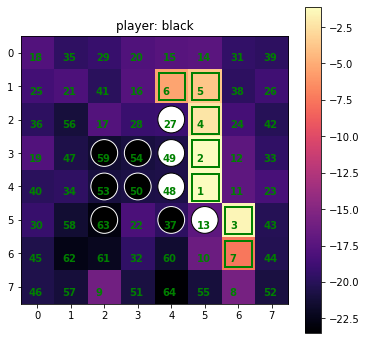

37 37
[18, 25, 29, 41, 43, 46, 49, 52]


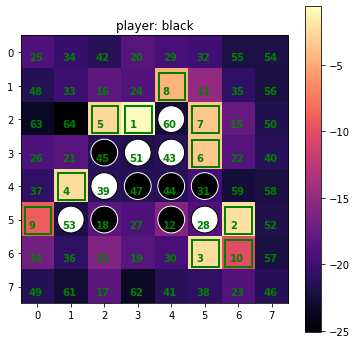

19 19
[18, 29, 38, 43, 50, 52]


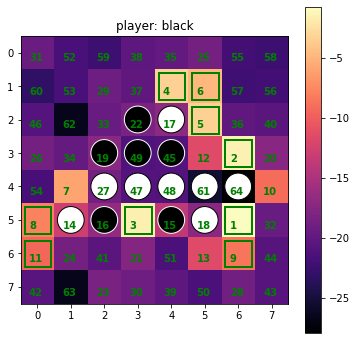

46 46
[11, 17, 18, 21, 43, 49, 50, 52, 53, 54]


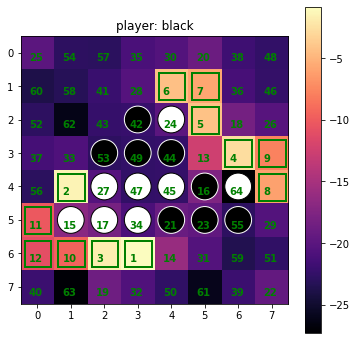

51 51
[18, 21, 47, 50, 52, 54, 60]


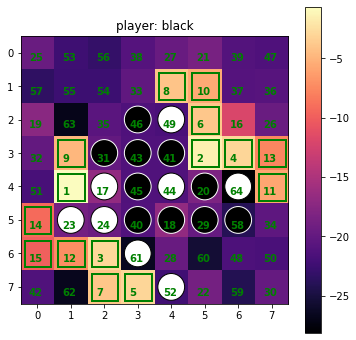

33 33
[11, 18, 21, 24, 25, 30, 32, 47, 50, 52, 54]


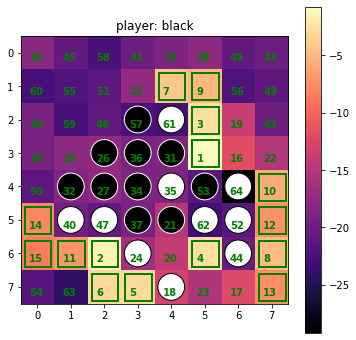

29 29
[10, 11, 18, 21, 24, 25, 30, 32, 52]


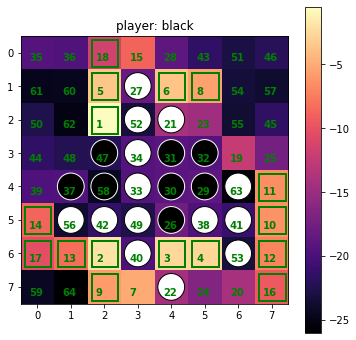

18 18
[9, 10, 17, 21, 22, 24, 25, 30, 32, 40, 52, 53]


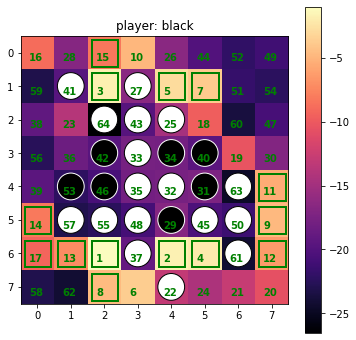

50 50
[17, 21, 24, 25, 30, 32, 40, 49, 52, 53, 58, 59]


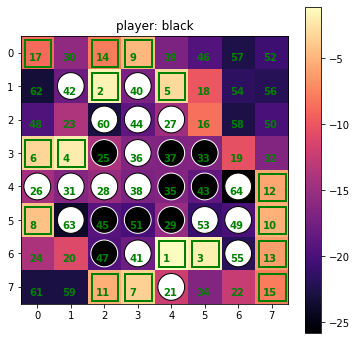

52 52
[17, 21, 25, 30, 49, 53, 58, 59, 61]


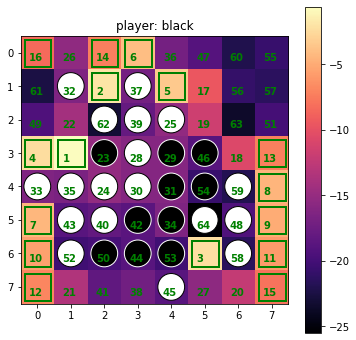

25 25
[17, 21, 24, 30, 53, 58, 59]


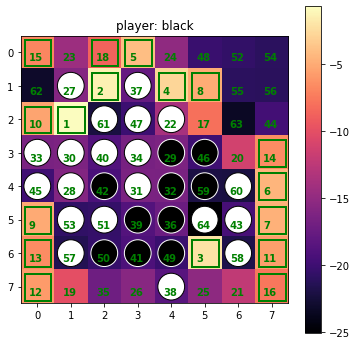

17 17
[10, 16, 21, 30, 53, 58, 59, 61]


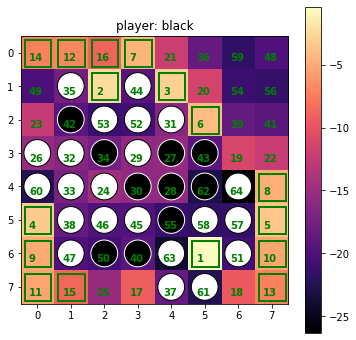

53 53
[10, 16, 21, 22, 30, 57, 58, 59]


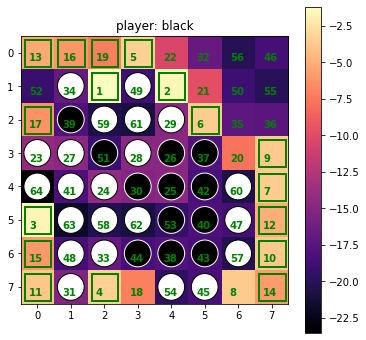

10 10
[1, 2, 3, 12, 16, 21, 22, 30, 59]


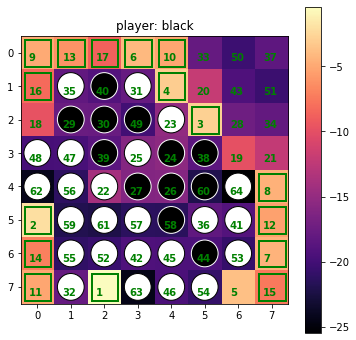

58 58
[1, 3, 12, 16, 21, 22, 30]


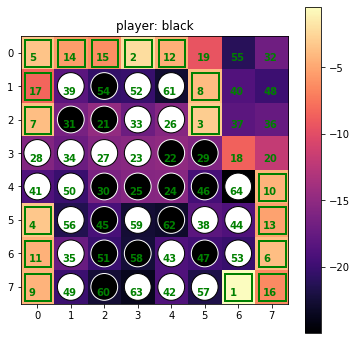

62 62
[1, 2, 3, 8, 16, 21, 22, 30, 63]


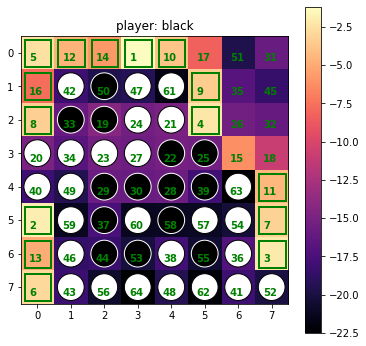

3 3
[1, 2, 4, 8, 16, 21, 22, 30]


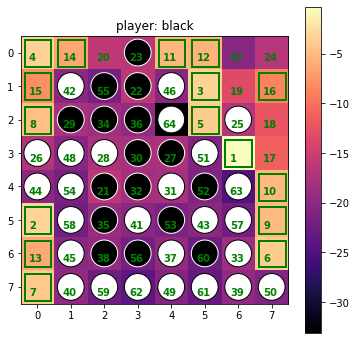

30 30
[1, 2, 4, 8, 16, 21, 23, 31]


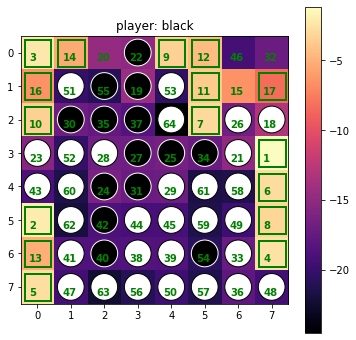

31 31
[1, 2, 4, 8, 16, 21, 39]


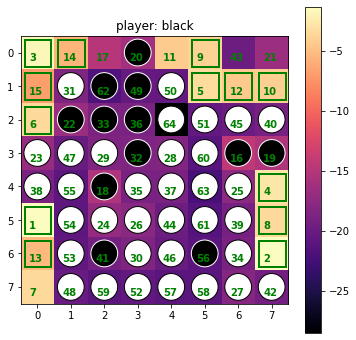

40 40
[1, 2, 4, 8, 16, 39, 48]


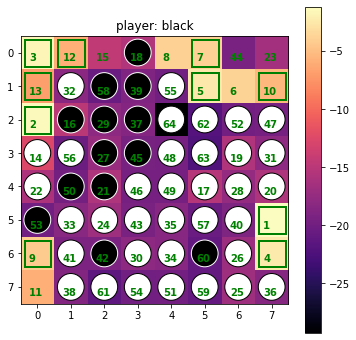

47 47
[1, 2, 4, 8, 16, 48, 55]


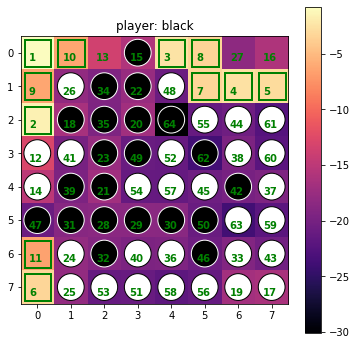

0 0
[1, 2, 4, 8, 16, 48]


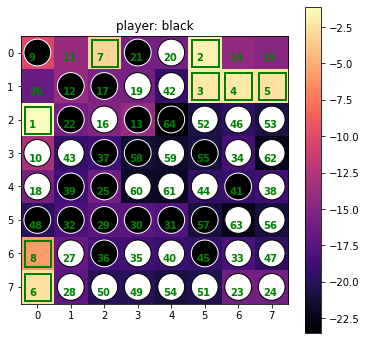

16 16
[1, 2, 8]


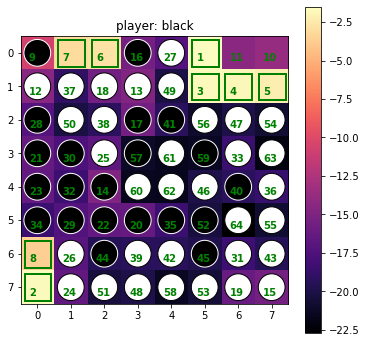

5 5
[13, 48]


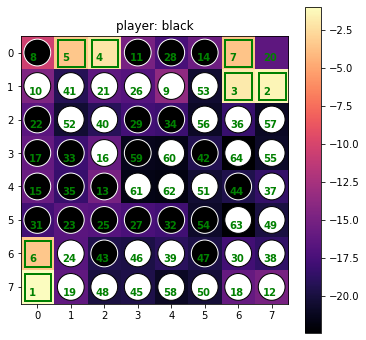

56 56
[48]


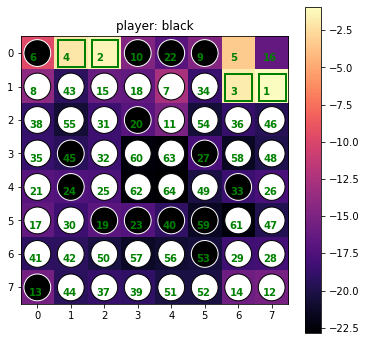

15 15
[7, 14]


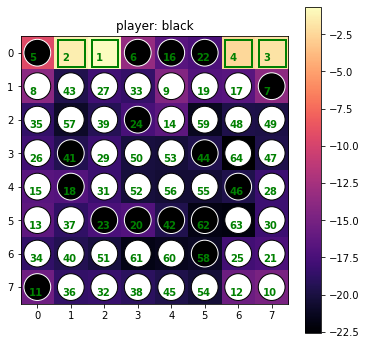

2 2
[1, 7]


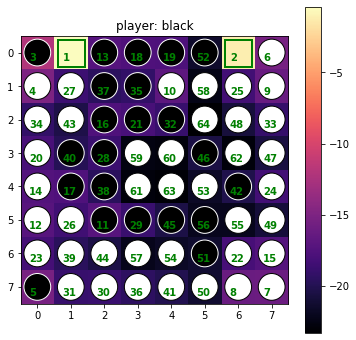

1 1
player: white was skipped


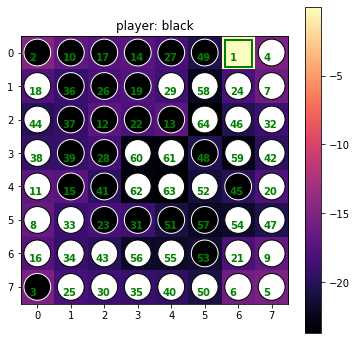

6 6
wrong action: 56 correct: 3


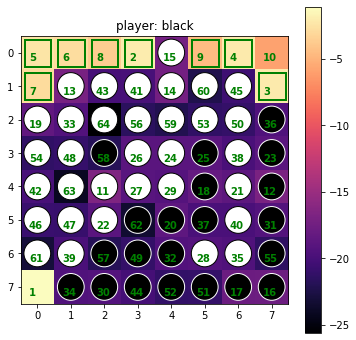

wrong action: 32 correct: 20


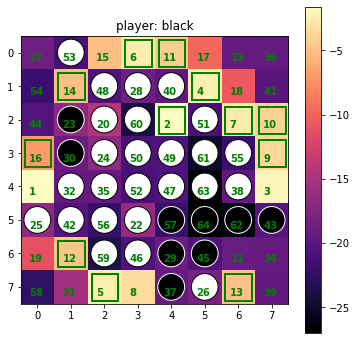

wrong action: 0 correct: 2


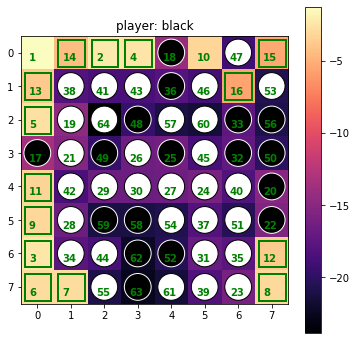

AI: black
win: white 3 : black 7
acc: 0.9902
Right: 302 Wrong: 3


In [ ]:
model = policy_model
AI = black
acc = [0, 0] #True, False
win = [0, 0] # white, black
for play in range(10):
  model.eval()
  env.reset()
  while not env.done:
    #env.render()
    player = env.player
    posts, _, _ = env.next_place
    if len(posts) > 0:#black = policy model
      org_state = env.render("rgb_array").copy()
      state = org_state.astype("float32")
      white_st = np.where(state == 3 - player, 1, 0)
      black_st = np.where(state == player, 1, 0)
      bw_st = np.where(state > 0, 1, 0)
      state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
      state = torch.tensor(state).float()
      state = state.to(device)
      with torch.no_grad():
        pred = model(state)
        pred_action = pred.max(1)[1].item()
        tposts = torch.tensor([posts]).long().to(device)
        toplace = pred.gather(1, tposts)
        
        pred = nn.LogSoftmax(dim = 1)(pred)
        pred = pred.clone().detach().to('cpu').numpy()
      
      if player == AI:
        if play == 0:
          policy_heatmap(org_state, pred, posts, player)
        placeid = toplace.max(1)[1]
        action = tposts[0][placeid]
      else:
        if play == 0:
          print(posts)
        action = torch.tensor(-1, device = device, dtype = torch.long)

    else:
      if play == 0:
        print(f"player: {color[player-1]} was skipped")

    _, r_action, _, reward, _, player = env.step(action.item())
    if player != AI:
      if play == 0:
        print(pred_action, r_action)
      if r_action < 0:
        pass #skipped
      elif pred_action == r_action:
        acc[0] += 1
      else:
        acc[1] += 1
        print(f"wrong action: {pred_action} correct: {r_action}")
        policy_heatmap(org_state, pred, posts, 3-player)
  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  win[winner-1] += 1

#env.render()

print(f"AI: {color[AI-1]}")
print(f"win: white {win[0]} : black {win[1]}")
print(f"acc: {acc[0]/sum(acc):.4f}")
print(f"Right: {acc[0]} Wrong: {acc[1]}")